device = cpu, grid_count = 9_350, scheduler = single-threaded
Memory = 4.20 Gb  Elapsed = 10.09 seconds

device = multi-cpu, grid_count = 9_350, scheduler = threads
Memory = 4.20 Gb  Elapsed = 8.73 seconds

device = gpu, grid_count = 9_350, scheduler = single-threaded
Memory = 4.20 Gb  Elapsed = 0.10 seconds

device = multi-gpu, grid_count = 9_350, scheduler = threads
Memory = 4.20 Gb  Elapsed = 0.17 seconds



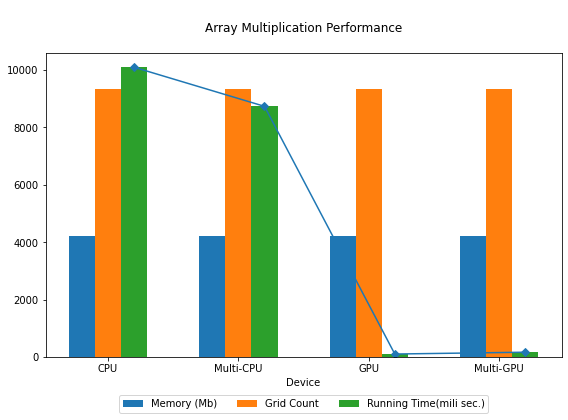

CPU times: user 18.9 s, sys: 4.38 s, total: 23.3 s
Wall time: 19.3 s


In [27]:
%%time 

from IPython.display import clear_output
clear_output()

import numpy
import cupy 
import dask.array as da
from dask_cuda import LocalCUDACluster
from dask.distributed import Client
from time import *
from time import perf_counter

devices = [ "CPU", "Multi-CPU", "GPU", "Multi-GPU" ]

memories = []
durations = []
grid_counts = []

for device in devices : 
    device = device.lower()
    rs = None

    scheduler = "single-threaded" 

    np = None 

    if device.__contains__( "multi" ) :
        scheduler = "threads"
    pass 

    if device.__contains__( "cpu" ):
        #print( f"device is {device}")
        np = numpy
    elif device.__contains__( "gpu" ) :
        #print( f"device is {device}")
        np = cupy
    pass

    then = perf_counter()

    s = 9_350

    print( f"device = {device}, grid_count = {s:_}, scheduler = {scheduler}" )

    t = np.random.rand( s*s ) + 1j*np.random.rand( s*s )
    t = t.reshape( s, s )
    x = da.from_array( t, chunks=(2**14, 2*14) )
    
    t = np.random.rand( s*s ) + 1j*np.random.rand( s*s )
    t = t.reshape( s, s )
    y = da.from_array( t, chunks=(2**14, 2*14) )    

    z = x*y
    z = z.compute(scheduler=scheduler)

    arrays = [ x, y, z ]

    bytes = 0 

    for array in arrays :
        bytes += array.nbytes
    pass

    elapsed = perf_counter() - then

    memories.append( bytes )
    durations.append( elapsed )
    grid_counts.append( s )

    print( f"Memory = {bytes/1e9:.2f} Gb", f" Elapsed = {elapsed:.2f} seconds" )
    print() 

    del t, x, y, z 
pass

from matplotlib import pyplot as plt

row_cnt = 1; col_cnt = 1
fig, charts = plt.subplots( row_cnt, col_cnt, figsize=( 8*col_cnt, 6*row_cnt) )
charts = charts.flatten() if row_cnt*col_cnt > 1 else [charts]
chart_idx = 0 
chart = charts[ chart_idx ]

n = len( devices )
x = numpy.arange( n )

memories = numpy.array( memories )/1e6
durations = numpy.array( durations )*1e3

w = 0.2 

idx = -1
chart.bar ( x + w*idx, memories, label="Memory (Mb)", width=w ); idx+=1
chart.bar ( x + w*idx, grid_counts, label="Grid Count", width=w ); idx+=1
chart.bar ( x + w*idx, durations, label="Running Time(mili sec.)", width=w );
chart.plot( x + w*idx, durations, marker="D" )

chart.set_title( f"\nArray Multiplication Performance\n" )
chart.set_xlabel( "Device\n" )
chart.set_xticks( x )
chart.set_xticklabels( devices ) 
chart.legend(loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=n)

plt.tight_layout()
plt.savefig( f"./result/array_multiplication_performance.png" )
plt.show()
